## Preliminaries

In [14]:
# Mount Google Drive.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import sys
from datetime import datetime
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set()

# Import local packages.
path = "/content/drive/MyDrive/Projects"

sys.path.append(f'{path}/quantus')
import quantus

sys.path.append(f'{path}/MetaQuantus')
import metaquantus
from metaquantus.utils import *
from metaquantus.models import *
import configs
from configs import setup_xai_methods, setup_estimators

#%load_ext autoreload
#%autoreload 2 

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

Mounted at /content/drive


In [5]:
path_results = "/content/drive/MyDrive/Projects/MetaQuantus/results/"

##########################
# Experimental settings. #
##########################

datasets = ["cMNIST", "MNIST", "fMNIST", "ImageNet"]
categories = ['Complexity', 'Localisation', 'Randomisation', 'Faithfulness', 'Robustness']
xai_methods = ['Gradient', 'Saliency', 'GradCAM', 'IntegratedGradients']
models = {"MNIST": "LeNet", "fMNIST": "LeNet", "cMNIST": "ResNet9", "ImageNet": "ResNet18"}

########################
# Estimators, metrics. #
########################

estimators = { "Complexity": ["Sparseness", "Complexity"], "Faithfulness": ["Faithfulness Correlation", "Pixel-Flipping"], "Localisation": ["Pointing-Game", "Relevance Rank Accuracy"], "Randomisation": ["Random Logit", "Model Parameter Randomisation Test"], "Robustness": ["Max-Sensitivity", "Local Lipschitz Estimate"], }
metrics = ['Sparseness', 'Complexity', 'Faithfulness Correlation', 'Pixel-Flipping', 'Pointing-Game', 'Relevance Rank Accuracy', 'Random Logit', 'Model Parameter Randomisation Test', 'Max-Sensitivity', 'Local Lipschitz Estimate']

#############################
# PerturbationTestBase suites, results. #
#############################
results = ['intra_scores', 'inter_scores', 'eval_scores', 'eval_scores_perturbed', 'indices_perturbed']
analyser_suite = ["Model Resilience Test", "Input Resilience Test",  "Model Adversary Test", "Input Adversary Test"]

### Plotting configs

In [6]:
hatches = ['/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*']
hatches = ['//', '\\\\', '||', '--', '++', 'xx', 'oo', 'OO', '..', '**'] 
hatches = ['/o', '\\|', '|*', '-\\', '+o', 'x*', 'o-', 'O|', 'O.', '*-']

In [7]:
sns.axes_style()

{'axes.facecolor': 'white',
 'axes.edgecolor': 'black',
 'axes.grid': False,
 'axes.axisbelow': 'line',
 'axes.labelcolor': 'black',
 'figure.facecolor': (1, 1, 1, 0),
 'grid.color': '#b0b0b0',
 'grid.linestyle': '-',
 'text.color': 'black',
 'xtick.color': 'black',
 'ytick.color': 'black',
 'xtick.direction': 'out',
 'ytick.direction': 'out',
 'lines.solid_capstyle': 'projecting',
 'patch.edgecolor': 'black',
 'patch.force_edgecolor': False,
 'image.cmap': 'viridis',
 'font.family': ['sans-serif'],
 'font.sans-serif': ['DejaVu Sans',
  'Bitstream Vera Sans',
  'Computer Modern Sans Serif',
  'Lucida Grande',
  'Verdana',
  'Geneva',
  'Lucid',
  'Arial',
  'Helvetica',
  'Avant Garde',
  'sans-serif'],
 'xtick.bottom': True,
 'xtick.top': False,
 'ytick.left': True,
 'ytick.right': False,
 'axes.spines.left': True,
 'axes.spines.bottom': True,
 'axes.spines.right': True,
 'axes.spines.top': True}

In [8]:
"""
data = resource_cmnist["Model Parameter Randomisation Test"]

with sns.axes_style("whitegrid"), sns.plotting_context("notebook", font_scale=1.5):

    
    sns.set_style({'font.family': 'serif', 'font.sans-serif': 'sans-serif'})

    fig, ax = plt.subplots(1,2, figsize=(10,4))
    scores = np.array(list(data["results_"]["Model Adversary Test"]["Gradient"].values())) 
    sns.distplot(scores[:, 0, :], color="green", label="${NORMAL}$", ax=ax[0])
    a = sns.distplot(scores[:, 1, :], color="red", label="${NORMAL}$", ax=ax[0])
    
    a_xticks = np.linspace(scores.min(), scores.max(), 4).round(2)
    
    scores = np.array(list(data["results_"]["Model Adversary Test"]["GradCAM"].values())) 
    sns.distplot(scores[:, 0, :], color="green", label="${NORMAL}$", ax=ax[1])
    b = sns.distplot(scores[:, 1, :], color="red", label="${RAN}$", ax=ax[1])
    
    b_xticks = np.linspace(scores.min(), scores.max(), 4).round(2)
    
    ax[0].title.set_text('Gradient')
    ax[1].title.set_text('GradCAM')

    a.set(yticklabels=[])  
    b.set(yticklabels=[]) 

    #a.set(xticklabels=a_xticks)  #ax[1].set_xticklabels([])
    #b.set(xticklabels=b_xticks)    
    
    a.set(ylabel=None)
    b.set(ylabel=None)
    
    #a.set(title='Penguins: Body Mass by Species for Gender')
    #plt.legend()
    
    fig.show()
""";

In [9]:
cnames = {
'aliceblue':            '#F0F8FF',
'antiquewhite':         '#FAEBD7',
'aqua':                 '#00FFFF',
'aquamarine':           '#7FFFD4',
'azure':                '#F0FFFF',
'beige':                '#F5F5DC',
'bisque':               '#FFE4C4',
'black':                '#000000',
'blanchedalmond':       '#FFEBCD',
'blue':                 '#0000FF',
'blueviolet':           '#8A2BE2',
'brown':                '#A52A2A',
'burlywood':            '#DEB887',
'cadetblue':            '#5F9EA0',
'chartreuse':           '#7FFF00',
'chocolate':            '#D2691E',
'coral':                '#FF7F50',
'cornflowerblue':       '#6495ED',
'cornsilk':             '#FFF8DC',
'crimson':              '#DC143C',
'cyan':                 '#00FFFF',
'darkblue':             '#00008B',
'darkcyan':             '#008B8B',
'darkgoldenrod':        '#B8860B',
'darkgray':             '#A9A9A9',
'darkgreen':            '#006400',
'darkkhaki':            '#BDB76B',
'darkmagenta':          '#8B008B',
'darkolivegreen':       '#556B2F',
'darkorange':           '#FF8C00',
'darkorchid':           '#9932CC',
'darkred':              '#8B0000',
'darksalmon':           '#E9967A',
'darkseagreen':         '#8FBC8F',
'darkslateblue':        '#483D8B',
'darkslategray':        '#2F4F4F',
'darkturquoise':        '#00CED1',
'darkviolet':           '#9400D3',
'deeppink':             '#FF1493',
'deepskyblue':          '#00BFFF',
'dimgray':              '#696969',
'dodgerblue':           '#1E90FF',
'firebrick':            '#B22222',
'floralwhite':          '#FFFAF0',
'forestgreen':          '#228B22',
'fuchsia':              '#FF00FF',
'gainsboro':            '#DCDCDC',
'ghostwhite':           '#F8F8FF',
'gold':                 '#FFD700',
'goldenrod':            '#DAA520',
'gray':                 '#808080',
'green':                '#008000',
'greenyellow':          '#ADFF2F',
'honeydew':             '#F0FFF0',
'hotpink':              '#FF69B4',
'indianred':            '#CD5C5C',
'indigo':               '#4B0082',
'ivory':                '#FFFFF0',
'khaki':                '#F0E68C',
'lavender':             '#E6E6FA',
'lavenderblush':        '#FFF0F5',
'lawngreen':            '#7CFC00',
'lemonchiffon':         '#FFFACD',
'lightblue':            '#ADD8E6',
'lightcoral':           '#F08080',
'lightcyan':            '#E0FFFF',
'lightgoldenrodyellow': '#FAFAD2',
'lightgreen':           '#90EE90',
'lightgray':            '#D3D3D3',
'lightpink':            '#FFB6C1',
'lightsalmon':          '#FFA07A',
'lightseagreen':        '#20B2AA',
'lightskyblue':         '#87CEFA',
'lightslategray':       '#778899',
'lightsteelblue':       '#B0C4DE',
'lightyellow':          '#FFFFE0',
'lime':                 '#00FF00',
'limegreen':            '#32CD32',
'linen':                '#FAF0E6',
'magenta':              '#FF00FF',
'maroon':               '#800000',
'mediumaquamarine':     '#66CDAA',
'mediumblue':           '#0000CD',
'mediumorchid':         '#BA55D3',
'mediumpurple':         '#9370DB',
'mediumseagreen':       '#3CB371',
'mediumslateblue':      '#7B68EE',
'mediumspringgreen':    '#00FA9A',
'mediumturquoise':      '#48D1CC',
'mediumvioletred':      '#C71585',
'midnightblue':         '#191970',
'mintcream':            '#F5FFFA',
'mistyrose':            '#FFE4E1',
'moccasin':             '#FFE4B5',
'navajowhite':          '#FFDEAD',
'navy':                 '#000080',
'oldlace':              '#FDF5E6',
'olive':                '#808000',
'olivedrab':            '#6B8E23',
'orange':               '#FFA500',
'orangered':            '#FF4500',
'orchid':               '#DA70D6',
'palegoldenrod':        '#EEE8AA',
'palegreen':            '#98FB98',
'paleturquoise':        '#AFEEEE',
'palevioletred':        '#DB7093',
'papayawhip':           '#FFEFD5',
'peachpuff':            '#FFDAB9',
'peru':                 '#CD853F',
'pink':                 '#FFC0CB',
'plum':                 '#DDA0DD',
'powderblue':           '#B0E0E6',
'purple':               '#800080',
'red':                  '#FF0000',
'rosybrown':            '#BC8F8F',
'royalblue':            '#4169E1',
'saddlebrown':          '#8B4513',
'salmon':               '#FA8072',
'sandybrown':           '#FAA460',
'seagreen':             '#2E8B57',
'seashell':             '#FFF5EE',
'sienna':               '#A0522D',
'silver':               '#C0C0C0',
'skyblue':              '#87CEEB',
'slateblue':            '#6A5ACD',
'slategray':            '#708090',
'snow':                 '#FFFAFA',
'springgreen':          '#00FF7F',
'steelblue':            '#4682B4',
'tan':                  '#D2B48C',
'teal':                 '#008080',
'thistle':              '#D8BFD8',
'tomato':               '#FF6347',
'turquoise':            '#40E0D0',
'violet':               '#EE82EE',
'wheat':                '#F5DEB3',
'white':                '#FFFFFF',
'whitesmoke':           '#F5F5F5',
'yellow':               '#FFFF00',
'yellowgreen':          '#9ACD32'}

## Analyse sanity checks

In [15]:
# Mount Google Drive.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Get benchmarking data.
path = Path(path_results+"adversarial/")    
[str(f.stem) for f in list(path.iterdir())]

In [23]:
def get_mean_std(score_type: str, expectation: str, scores: np.array):
    if "IAC" in score_type:
        score_means = scores.mean(axis=(0, 2))
    else:
        score_means = scores.mean(axis=1)
    print(f"\t{score_type}={score_means.mean():.4f} ({score_means.std():.3f}) \t-----\tExpectation{expectation}")

today = "23112022" #datetime.today().strftime("%d%m%Y")
iterations = 5
nr_perturbations = 10
perturbation_type = "Model"

In [24]:
uid_ar = "b1ed"
print("\nControlled scenario 1: the estimator always returns the same score, independent of perturbation (deterministic sampling).\n")
print(f"{perturbation_type} Perturbation Test")

inter_scores_nr = np.array(load_obj(path_results+"adversarial/", fname=f"{today}_Complement_AR_inter_scores_{uid_ar}", use_json=True)[f"{perturbation_type} Resilience Test"]).reshape(iterations, nr_perturbations)
intra_scores_nr = load_obj(path_results+"adversarial/", fname=f"{today}_Complement_AR_intra_scores_{uid_ar}", use_json=True)
intra_scores_nr = np.array(list(intra_scores_nr[f"{perturbation_type} Resilience Test"].values())).reshape(len(xai_methods), iterations, nr_perturbations)
inter_scores_ar = np.array(load_obj(path_results+"adversarial/", fname=f"{today}_Complement_AR_inter_scores_{uid_ar}", use_json=True)[f"{perturbation_type} Adversary Test"]).reshape(iterations, nr_perturbations)
intra_scores_ar = load_obj(path_results+"adversarial/", fname=f"{today}_Complement_AR_intra_scores_{uid_ar}", use_json=True)
intra_scores_ar = np.array(list(intra_scores_ar[f"{perturbation_type} Adversary Test"].values())).reshape(len(xai_methods), iterations, nr_perturbations)
s
get_mean_std(score_type="IAC_{NR}", expectation="=1.0 (should succeed: scores are the same!)", scores=intra_scores_nr)
get_mean_std(score_type="IAC_{AR}", expectation="=0.0 (should fail: scores are not different!)", scores=intra_scores_ar)
get_mean_std(score_type="IEC_{NR}", expectation="=1.0 (should succed: scores, then rankings are the same!)", scores=inter_scores_nr) 
get_mean_std(score_type="IEC_{AR}", expectation="=0.0 (should fail: does not fulfil ranking condition '<' since '=')", scores=inter_scores_ar) 

uid_nr = "4ee0"
print("\nControlled scenario 2: the estimator always returns scores from a different distribution (stochastic sampling).\n")
print(f"{perturbation_type} Perturbation Test")

inter_scores_nr = np.array(load_obj(path_results+"adversarial/", fname=f"{today}_Complement_NR_inter_scores_{uid_nr}", use_json=True)[f"{perturbation_type} Resilience Test"]).reshape(iterations, nr_perturbations)
intra_scores_nr = load_obj(path_results+"adversarial/", fname=f"{today}_Complement_NR_intra_scores_{uid_nr}", use_json=True)
intra_scores_nr = np.array(list(intra_scores_nr[f"{perturbation_type} Resilience Test"].values())).reshape(len(xai_methods), iterations, nr_perturbations)
inter_scores_ar = np.array(load_obj(path_results+"adversarial/", fname=f"{today}_Complement_NR_inter_scores_{uid_nr}", use_json=True)[f"{perturbation_type} Adversary Test"]).reshape(iterations, nr_perturbations)
intra_scores_ar = load_obj(path_results+"adversarial/", fname=f"{today}_Complement_NR_intra_scores_{uid_nr}", use_json=True)
intra_scores_ar = np.array(list(intra_scores_ar[f"{perturbation_type} Adversary Test"].values())).reshape(len(xai_methods), iterations, nr_perturbations)

get_mean_std(score_type="IAC_{NR}", expectation="≈0.0 (should fail: scores are different!)", scores=intra_scores_nr)
get_mean_std(score_type="IAC_{AR}", expectation="≈1.0 (should succeed: scores are different!)", scores=intra_scores_ar)
get_mean_std(score_type="IEC_{NR}", expectation="≈0.25 (should be =1/L, where L=4: no diff in scores between explainers)", scores=inter_scores_nr)
get_mean_std(score_type="IEC_{AR}", expectation="≈0.0 (depends on the sampling distributions and its variation!)", scores=inter_scores_ar) 


Controlled scenario 1: the estimator always returns the same score, independent of perturbation (deterministic sampling).

Model Perturbation Test
	IAC_{NR}=1.0000 (0.000) 	-----	Expectation=1.0 (should succeed: scores are the same!)
	IAC_{AR}=0.0000 (0.000) 	-----	Expectation=0.0 (should fail: scores are not different!)
	IEC_{NR}=1.0000 (0.000) 	-----	Expectation=1.0 (should succed: scores, then rankings are the same!)
	IEC_{AR}=0.0000 (0.000) 	-----	Expectation=0.0 (should fail: does not fulfil ranking condition '<' since '=')

Controlled scenario 2: the estimator always returns scores from a different distribution (stochastic sampling).

Model Perturbation Test
	IAC_{NR}=0.0000 (0.000) 	-----	Expectation≈0.0 (should fail: scores are different!)
	IAC_{AR}=1.0000 (0.000) 	-----	Expectation≈1.0 (should succeed: scores are different!)
	IEC_{NR}=0.2494 (0.002) 	-----	Expectation≈0.25 (should be =1/L, where L=4: no diff in scores between explainers)
	IEC_{AR}=0.0000 (0.000) 	-----	Expect

In [ ]:
def plot_estimator_area(benchmark: dict,
                        estimator_category: str, 
                        estimator_name: str,
                        perturbation_type: str
                        ):
    
    intra_scores_res = np.array(list(benchmark[estimator_category][estimator_name]["intra_scores"][f"{perturbation_type} Resilience Test"].values())).flatten()
    intra_scores_adv = np.array(list(benchmark[estimator_category][estimator_name]["intra_scores"][f"{perturbation_type} Adversary Test"].values())).flatten()
    inter_scores_res = np.array(benchmark[estimator_category][estimator_name]['inter_scores'][f"{perturbation_type} Resilience Test"])
    inter_scores_adv = np.array(benchmark[estimator_category][estimator_name]['inter_scores'][f"{perturbation_type} Adversary Test"])

    fig = plt.figure(figsize=(5, 5))
    ax = plt.axes()
    plt.grid()

    X_gt = [-1, 0, 1, 0]
    Y_gt = [0, 1, 0, -1]
    X_area = [-intra_scores_adv.mean(), 0, inter_scores_adv.mean(), 0]
    Y_area = [0, intra_scores_res.mean(), 0, -inter_scores_res.mean()]

    #print([intra_scores_adv.mean(), inter_scores_adv.mean(), intra_scores_res.mean(), inter_scores_res.mean()])
    plt.fill(X_gt, Y_gt, color="black", alpha=0.1)
    plt.fill(X_area, Y_area, color="blue", alpha=0.25)

    # Annotate.
    plt.annotate("${IAC}_{AR}$"+f"={intra_scores_adv.mean():.2f}", (-intra_scores_adv.mean(), 0.1), fontsize=12)
    plt.annotate("${IAC}_{NR}$"+f"={intra_scores_res.mean():.2f}", (-0.2, intra_scores_res.mean()+0.05), fontsize=12)
    plt.annotate("${IEC}_{AR}$"+f"={inter_scores_adv.mean():.2f}", (inter_scores_adv.mean(), 0.1), fontsize=12)
    plt.annotate("${IEC}_{NR}$"+f"={inter_scores_res.mean():.2f}", (-0.2, -inter_scores_res.mean()-0.1), fontsize=12)
    
    # Labels.
    ax.set_xticklabels(["", "1", "", "0.5", "",  "0", "", "0.5", "", "1", ""], fontsize=15)
    ax.set_yticklabels(["", "1", "", "0.5", "",  "0", "", "0.5", "", "1", ""], fontsize=15)
    plt.title(f"{estimator_name}", fontsize=20)
    
    # Limits.
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)
    
    return fig

## Analyse benchmarking data

In [25]:
# Get benchmarking data.
path = Path(path_results+"benchmarks/")    
[str(f.stem) for f in list(path.iterdir()) if "benchmark_exercise" in str(f.stem)]

['10112022_MNIST_benchmark_exercise_86a6_',
 '10112022_fMNIST_benchmark_exercise_e0ba_',
 '09112022_cMNIST_benchmark_exercise_0b31_',
 '11112022_cMNIST_benchmark_exercise_5af8_',
 '09112022_MNIST_benchmark_exercise_28d0_non_normalised_xai',
 '10112022_fMNIST_benchmark_exercise_1509_non_normalised_xai',
 '23112022_MNIST_benchmark_exercise_b274_',
 '23112022_fMNIST_benchmark_exercise_e169_',
 '23112022_cMNIST_benchmark_exercise_aefa_']

In [27]:
# Load an object.
dataset_name = "MNIST"
benchmark_mnist = load_obj(path_results+"benchmarks/", fname=f"23112022_{dataset_name}_benchmark_exercise_b274_", use_json=True)[dataset_name]["LeNet"]

dataset_name = "fMNIST"
benchmark_fmnist = load_obj(path_results+"benchmarks/", fname=f"23112022_{dataset_name}_benchmark_exercise_e169_", use_json=True)[dataset_name]["LeNet"]

dataset_name = "cMNIST"
benchmark_cmnist = load_obj(path_results+"benchmarks/", fname=f"23112022_{dataset_name}_benchmark_exercise_aefa_", use_json=True)[dataset_name]["ResNet9"]

### Area graph single

In [28]:
def plot_estimator_area(benchmark: dict,
                        estimator_category: str, 
                        estimator_name: str,
                        perturbation_type: str
                        ):
    
    intra_scores_res = np.array(list(benchmark[estimator_category][estimator_name]["intra_scores"][f"{perturbation_type} Resilience Test"].values())).flatten()
    intra_scores_adv = np.array(list(benchmark[estimator_category][estimator_name]["intra_scores"][f"{perturbation_type} Adversary Test"].values())).flatten()
    inter_scores_res = np.array(benchmark[estimator_category][estimator_name]['inter_scores'][f"{perturbation_type} Resilience Test"])
    inter_scores_adv = np.array(benchmark[estimator_category][estimator_name]['inter_scores'][f"{perturbation_type} Adversary Test"])

    fig = plt.figure(figsize=(5, 5))
    ax = plt.axes()
    plt.grid()

    X_gt = [-1, 0, 1, 0]
    Y_gt = [0, 1, 0, -1]
    X_area = [-intra_scores_adv.mean(), 0, inter_scores_adv.mean(), 0]
    Y_area = [0, intra_scores_res.mean(), 0, -inter_scores_res.mean()]

    #print([intra_scores_adv.mean(), inter_scores_adv.mean(), intra_scores_res.mean(), inter_scores_res.mean()])
    plt.fill(X_gt, Y_gt, color="black", alpha=0.1)
    plt.fill(X_area, Y_area, color="blue", alpha=0.25)

    # Annotate.
    plt.annotate("${IAC}_{AR}$"+f"={intra_scores_adv.mean():.2f}", (-intra_scores_adv.mean(), 0.1), fontsize=12)
    plt.annotate("${IAC}_{NR}$"+f"={intra_scores_res.mean():.2f}", (-0.2, intra_scores_res.mean()+0.05), fontsize=12)
    plt.annotate("${IEC}_{AR}$"+f"={inter_scores_adv.mean():.2f}", (inter_scores_adv.mean(), 0.1), fontsize=12)
    plt.annotate("${IEC}_{NR}$"+f"={inter_scores_res.mean():.2f}", (-0.2, -inter_scores_res.mean()-0.1), fontsize=12)
    
    # Labels.
    ax.set_xticklabels(["", "1", "", "0.5", "",  "0", "", "0.5", "", "1", ""], fontsize=15)
    ax.set_yticklabels(["", "1", "", "0.5", "",  "0", "", "0.5", "", "1", ""], fontsize=15)
    plt.title(f"{estimator_name}", fontsize=20)
    
    # Limits.
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)
    
    return fig

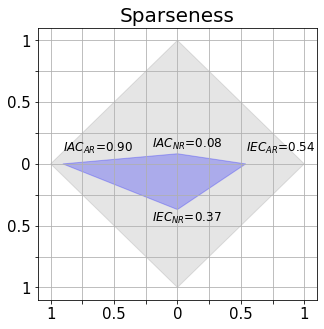

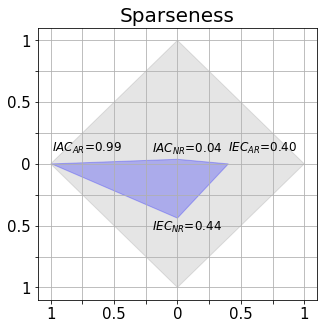

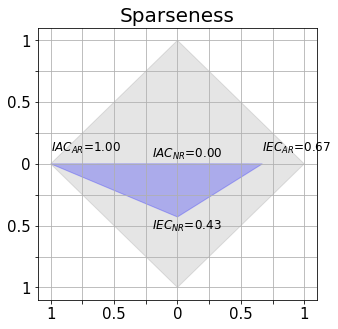

In [29]:
estimator_category = "Complexity"
estimator_name = "Sparseness" 
perturbation_type = "Input"

plot_estimator_area(benchmark_mnist, estimator_category, estimator_name, perturbation_type);
plot_estimator_area(benchmark_fmnist, estimator_category, estimator_name, perturbation_type);
plot_estimator_area(benchmark_cmnist, estimator_category, estimator_name, perturbation_type);

In [14]:
#intra_scores_adv  # (L x K x I)

In [15]:
#inter_scores_adv # (K x I)

dict_keys(['intra_scores', 'inter_scores', 'eval_scores', 'eval_scores_perturbed', 'indices_perturbed'])

In [40]:
np.unique(benchmark_mnist[estimator_category][estimator_name]["indices_perturbed"][analyser_name][i][p])

array([ True])

In [44]:
type(benchmark_mnist[estimator_category][estimator_name]["indices_perturbed"][analyser_name][i][p][0]) == bool

True

9.3383772061129e-40
256


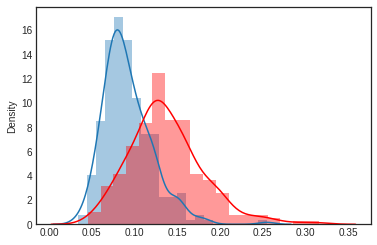

In [70]:

def compute_p_value(
        q: np.array,
        q_hat: np.array,
        indices: np.array,
        measure: Callable = scipy.stats.wilcoxon,
        alternative: str = "two-sided",
        zero_method: str = "zsplit"
) -> float:
    """Compare evaluation scores by computing the p-value to test if the scores are statistically different.
    Returns p-value Wilcoxon Signed Rank test to see that the scores originates from different distributions.
    """
    #assert isinstance(indices[0], np.bool_), "Indices must be of type bool."
    #assert (
    #        q.ndim == 1 and q_hat.ndim == 1 and indices.ndim == 1
    #), "All inputs should be 1D."

    q = np.array(q)[np.array(indices)]
    q_hat = np.array(q_hat)[np.array(indices)]

    if all(q == q_hat):
        return 1.0

    return q, q_hat, measure(q, q_hat, alternative=alternative, zero_method=zero_method)[1]

benchmark = benchmark_cmnist
analyser_name = "Model Resilience Test"
method = "IntegratedGradients"
estimator_category = "Robustness"
estimator_name = "Max-Sensitivity"
i = "0"
p = 0

q, q_hat, p_value = compute_p_value(
q=benchmark[estimator_category][estimator_name]["eval_scores"][analyser_name][method],
q_hat=benchmark[estimator_category][estimator_name]["eval_scores_perturbed"][analyser_name][i][method][
    p
],
indices=benchmark[estimator_category][estimator_name]["indices_perturbed"][analyser_name][i][p],)
print(p_value)
print(len(q))
sns.distplot(q)
sns.distplot(q_hat, color="red")

### Area graph full

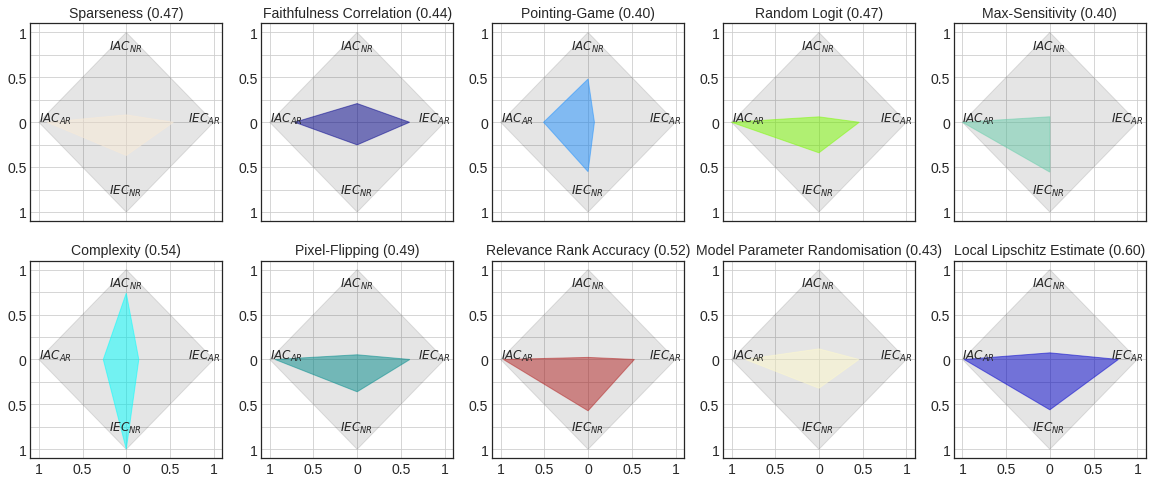

In [30]:
benchmark = benchmark_mnist 
plt.style.use(['seaborn-white'])
perturbation_type = "Input"

fig, axs = plt.subplots(2, 5, sharex=True, figsize=(20, 8)) #sharex=True, sharey=True, 


for ex1, (estimator_category, metrics) in enumerate(estimators.items()):
    for ex2, estimator_name in enumerate(metrics):

        intra_scores_res = np.array(list(benchmark[estimator_category][estimator_name]["intra_scores"][f"{perturbation_type} Resilience Test"].values())).flatten()
        intra_scores_adv = np.array(list(benchmark[estimator_category][estimator_name]["intra_scores"][f"{perturbation_type} Adversary Test"].values())).flatten()
        inter_scores_res = np.array(benchmark[estimator_category][estimator_name]['inter_scores'][f"{perturbation_type} Resilience Test"])
        inter_scores_adv = np.array(benchmark[estimator_category][estimator_name]['inter_scores'][f"{perturbation_type} Adversary Test"])
        
        X_gt = [-1, 0, 1, 0]
        Y_gt = [0, 1, 0, -1]
        X_area = [-intra_scores_adv.mean(), 0, inter_scores_adv.mean(), 0]
        Y_area = [0, intra_scores_res.mean(), 0, -inter_scores_res.mean()]

        scores = np.array([intra_scores_adv.mean(), inter_scores_adv.mean(), intra_scores_res.mean(), inter_scores_res.mean()])
        axs[ex2, ex1].fill(X_gt, Y_gt, color="black", alpha=0.1)
        axs[ex2, ex1].fill(X_area, Y_area, color=list(cnames.values())[(ex1*20)+(ex2+1)], alpha=0.5)

        # Annotate.
        #axs[ex2, ex1].annotate("${IAC}_{AR}$"+f"={intra_scores_adv.mean():.2f}", (-intra_scores_adv.mean(), 0.1), fontsize=12)
        #axs[ex2, ex1].annotate("${IAC}_{NR}$"+f"={intra_scores_res.mean():.2f}", (-0.2, intra_scores_res.mean()+0.05), fontsize=12)
        #axs[ex2, ex1].annotate("\n\n${IEC}_{AR}$"+f"={inter_scores_adv.mean():.2f}", (inter_scores_adv.mean(), 0.1), fontsize=12)
        #axs[ex2, ex1].annotate("${IEC}_{NR}$"+f"={inter_scores_res.mean():.2f}", (-0.2, -inter_scores_res.mean()-0.1), fontsize=12)
        
        axs[ex2, ex1].annotate("${IAC}_{AR}$", (-1, 0), fontsize=12)
        axs[ex2, ex1].annotate("${IAC}_{NR}$", (-0.2, 0.8), fontsize=12)
        axs[ex2, ex1].annotate("${IEC}_{AR}$", (0.7, 0), fontsize=12)
        axs[ex2, ex1].annotate("${IEC}_{NR}$", (-0.2, -0.8), fontsize=12)
        
        # Labels.
        axs[ex2, ex1].set_xticklabels(["", "1", "0.5",  "0", "0.5", "1"], fontsize=14)
        
        axs[ex2, ex1].set_yticklabels(["", "1", "", "0.5", "",  "0", "", "0.5", "", "1", ""], fontsize=14)
        if estimator_name == "Model Parameter Randomisation Test":
            estimator_name = "Model Parameter Randomisation"
        axs[ex2, ex1].set_title(f"{estimator_name} ({scores.mean():.2f})", fontsize=14)
        axs[ex2, ex1].grid()

        #axs[ex2, ex1].plot([0, 0], [-1, 1], '--bo', label='NR')
        #axs[ex2, ex1].plot([-1, 1], [0, 0], '--go', label='AR')

        # Limits.
        #axs[ex2, ex1].set_xlim(-1.6, 1.6)
        #axs[ex2, ex1].set_ylim(-1.6, 1.6)
        plt.grid()
            

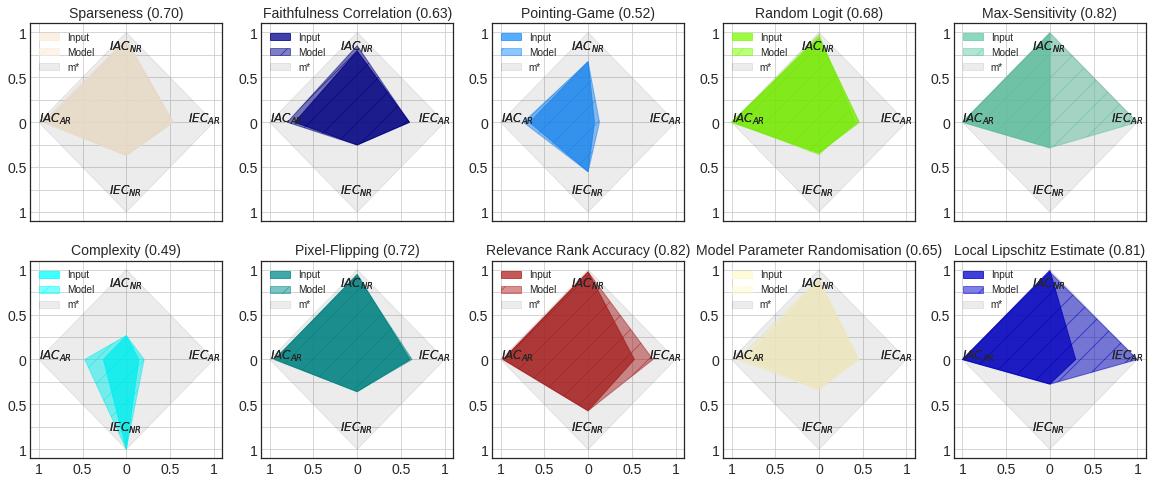

In [45]:
benchmark = benchmark_mnist 
plt.style.use(['seaborn-white'])
perturbation_type = "Input"

fig, axs = plt.subplots(2, 5, sharex=True, figsize=(20, 8)) #sharex=True, sharey=True, 


for ex1, (estimator_category, metrics) in enumerate(estimators.items()):
    for ex2, estimator_name in enumerate(metrics):
        for px, perturbation_type in enumerate(["Input", "Model"]):

            intra_scores_res = np.array(list(benchmark[estimator_category][estimator_name]["intra_scores"][f"{perturbation_type} Resilience Test"].values())).flatten()
            intra_scores_adv = np.array(list(benchmark[estimator_category][estimator_name]["intra_scores"][f"{perturbation_type} Adversary Test"].values())).flatten()
            inter_scores_res = np.array(benchmark[estimator_category][estimator_name]['inter_scores'][f"{perturbation_type} Resilience Test"])
            inter_scores_adv = np.array(benchmark[estimator_category][estimator_name]['inter_scores'][f"{perturbation_type} Adversary Test"])
            
            X_gt = [-1, 0, 1, 0]
            Y_gt = [0, 1, 0, -1]
            X_area = [-intra_scores_adv.mean(), 0, inter_scores_adv.mean(), 0]
            Y_area = [0, intra_scores_res.mean(), 0, -inter_scores_res.mean()]

            scores = np.array([intra_scores_adv.mean(), inter_scores_adv.mean(), intra_scores_res.mean(), inter_scores_res.mean()])

            if perturbation_type == "Input":
                axs[ex2, ex1].fill(X_area, Y_area, color=list(cnames.values())[(ex1*20)+(ex2+1)], alpha=0.75, label=perturbation_type)
            else:
                axs[ex2, ex1].fill(X_area, Y_area, color=list(cnames.values())[(ex1*20)+(ex2+1)], alpha=0.5, label=perturbation_type, hatch = '/')
            
            if px == 1:
                axs[ex2, ex1].fill(X_gt, Y_gt, color="black", alpha=0.075, label="m*")

            # Annotate.
            #axs[ex2, ex1].annotate("${IAC}_{AR}$"+f"={intra_scores_adv.mean():.2f}", (-intra_scores_adv.mean(), 0.1), fontsize=12)
            #axs[ex2, ex1].annotate("${IAC}_{NR}$"+f"={intra_scores_res.mean():.2f}", (-0.2, intra_scores_res.mean()+0.05), fontsize=12)
            #axs[ex2, ex1].annotate("\n\n${IEC}_{AR}$"+f"={inter_scores_adv.mean():.2f}", (inter_scores_adv.mean(), 0.1), fontsize=12)
            #axs[ex2, ex1].annotate("${IEC}_{NR}$"+f"={inter_scores_res.mean():.2f}", (-0.2, -inter_scores_res.mean()-0.1), fontsize=12)
            
            axs[ex2, ex1].annotate("${IAC}_{AR}$", (-1, 0), fontsize=12)
            axs[ex2, ex1].annotate("${IAC}_{NR}$", (-0.2, 0.8), fontsize=12)
            axs[ex2, ex1].annotate("${IEC}_{AR}$", (0.7, 0), fontsize=12)
            axs[ex2, ex1].annotate("${IEC}_{NR}$", (-0.2, -0.8), fontsize=12)
        
        # Labels.
        axs[ex2, ex1].set_xticklabels(["", "1", "0.5",  "0", "0.5", "1"], fontsize=14)
        
        axs[ex2, ex1].set_yticklabels(["", "1", "", "0.5", "",  "0", "", "0.5", "", "1", ""], fontsize=14)
        if estimator_name == "Model Parameter Randomisation Test":
            estimator_name = "Model Parameter Randomisation"
        axs[ex2, ex1].set_title(f"{estimator_name} ({scores.mean():.2f})", fontsize=14)
        axs[ex2, ex1].grid()
        axs[ex2, ex1].legend(loc="upper left")

        #axs[ex2, ex1].plot([0, 0], [-1, 1], '--bo', label='NR')
        #axs[ex2, ex1].plot([-1, 1], [0, 0], '--go', label='AR')

        # Limits.
        #axs[ex2, ex1].set_xlim(-1.6, 1.6)
        #axs[ex2, ex1].set_ylim(-1.6, 1.6)
        plt.grid()
            

In [ ]:
plt.style.use(['seaborn-white'])
perturbation_type = "Input"

fig, axs = plt.subplots(2, 5, sharex=True, figsize=(20, 8)) #sharex=True, sharey=True, 


for ex1, (estimator_category, metrics) in enumerate(estimators.items()):
    for ex2, estimator_name in enumerate(metrics):

        intra_scores_res = np.array(list(benchmark[estimator_category][estimator_name]["intra_scores"][f"{perturbation_type} Resilience Test"].values())).flatten()
        intra_scores_adv = np.array(list(benchmark[estimator_category][estimator_name]["intra_scores"][f"{perturbation_type} Adversary Test"].values())).flatten()
        inter_scores_res = np.array(benchmark[estimator_category][estimator_name]['inter_scores'][f"{perturbation_type} Resilience Test"])
        inter_scores_adv = np.array(benchmark[estimator_category][estimator_name]['inter_scores'][f"{perturbation_type} Adversary Test"])
        
        X_gt = [-1, 0, 1, 0]
        Y_gt = [0, 1, 0, -1]
        X_area = [-intra_scores_adv.mean(), 0, inter_scores_adv.mean(), 0]
        Y_area = [0, intra_scores_res.mean(), 0, -inter_scores_res.mean()]

        scores = np.array([intra_scores_adv.mean(), inter_scores_adv.mean(), intra_scores_res.mean(), inter_scores_res.mean()])
        axs[ex2, ex1].fill(X_gt, Y_gt, color="black", alpha=0.1)
        axs[ex2, ex1].fill(X_area, Y_area, color=list(cnames.values())[(ex1*20)+(ex2+1)], alpha=0.5)

        # Annotate.
        #axs[ex2, ex1].annotate("${IAC}_{AR}$"+f"={intra_scores_adv.mean():.2f}", (-intra_scores_adv.mean(), 0.1), fontsize=12)
        #axs[ex2, ex1].annotate("${IAC}_{NR}$"+f"={intra_scores_res.mean():.2f}", (-0.2, intra_scores_res.mean()+0.05), fontsize=12)
        #axs[ex2, ex1].annotate("\n\n${IEC}_{AR}$"+f"={inter_scores_adv.mean():.2f}", (inter_scores_adv.mean(), 0.1), fontsize=12)
        #axs[ex2, ex1].annotate("${IEC}_{NR}$"+f"={inter_scores_res.mean():.2f}", (-0.2, -inter_scores_res.mean()-0.1), fontsize=12)
        
        axs[ex2, ex1].annotate("${IAC}_{AR}$", (-1, 0), fontsize=12)
        axs[ex2, ex1].annotate("${IAC}_{NR}$", (-0.2, 0.8), fontsize=12)
        axs[ex2, ex1].annotate("${IEC}_{AR}$", (0.7, 0), fontsize=12)
        axs[ex2, ex1].annotate("${IEC}_{NR}$", (-0.2, -0.8), fontsize=12)
        
        # Labels.
        axs[ex2, ex1].set_xticklabels(["", "1", "0.5",  "0", "0.5", "1"], fontsize=14)
        
        axs[ex2, ex1].set_yticklabels(["", "1", "", "0.5", "",  "0", "", "0.5", "", "1", ""], fontsize=14)
        if estimator_name == "Model Parameter Randomisation Test":
            estimator_name = "Model Parameter Randomisation"
        axs[ex2, ex1].set_title(f"{estimator_name} ({scores.mean():.2f})", fontsize=14)
        axs[ex2, ex1].grid()

        #axs[ex2, ex1].plot([0, 0], [-1, 1], '--bo', label='NR')
        #axs[ex2, ex1].plot([-1, 1], [0, 0], '--go', label='AR')

        # Limits.
        #axs[ex2, ex1].set_xlim(-1.6, 1.6)
        #axs[ex2, ex1].set_ylim(-1.6, 1.6)
        plt.grid()
            

In [ ]:
# e.g. corners = [(2.0, 1.0), (4.0, 5.0), (7.0, 8.0)]
def Area(corners):
    n = len(corners) # of corners
    area = 0.0
    for i in range(n):
        j = (i + 1) % n
        area += corners[i][0] * corners[j][1]
        area -= corners[j][0] * corners[i][1]
    area = abs(area) / 2.0
    return area

In [ ]:
def compute_consistency_overlap(iac_score_nr: float,
                                iac_score_ar: float,
                                iec_score_nr: float,
                                iec_score_ar: float):
    pass


### In general, which faithfulness/ complexity/ robustness/ randomisation/ localisation measure is the best?

In [ ]:
def get_quick_stats(estimator_category: str, tests: list, estimators: dict):
    for estimator_name in estimators[estimator_category]:
        print(f"{estimator_name}\t")
        for test in tests:
            if "Resilience" in test:
                arrow = "⬆"
            else:
                arrow = "⬇"
            print(f"\t{test}\t")
            print(f"\t\tIntra ({arrow}): {get_statistics_intra_scores(benchmark[estimator_category][estimator_name]['intra_scores'], test=test)}\n\t\t" \
            f"Inter (⬆): {get_statistics_inter_scores(benchmark[estimator_category][estimator_name]['inter_scores'], test=test)}")

In [ ]:
get_quick_stats(estimator_category="Faithfulness", tests=analyser_suite, estimators=estimators)

Faithfulness Correlation	
	Model Resilience Test	
		Intra (⬆): (0.43291534771913087, 0.26704790998120126)
		Inter (⬆): (0.29697265625, 0.007193826296192115)
	Input Resilience Test	
		Intra (⬆): (0.5134696717803475, 0.3294217667384682)
		Inter (⬆): (0.2925537109375, 0.013423760953302494)
	Model Adversary Test	
		Intra (⬇): (0.258304451677822, 0.33331090833387034)
		Inter (⬆): (0.5988094617767824, 0.0059963673019729396)
	Input Adversary Test	
		Intra (⬇): (0.18616201881813377, 0.2800438795438413)
		Inter (⬆): (0.6006090673901017, 0.00398534448926149)
Pixel-Flipping	
	Model Resilience Test	
		Intra (⬆): (0.5534743811997412, 0.3080313741150198)
		Inter (⬆): (0.427392578125, 0.004958158901362693)
	Input Resilience Test	
		Intra (⬆): (0.5010081657855457, 0.30762110217307315)
		Inter (⬆): (0.4307373046875, 0.006965542110533517)
	Model Adversary Test	
		Intra (⬇): (0.05642619206106788, 0.18292807112455406)
		Inter (⬆): (0.6251921255360707, 0.14689803503108495)
	Input Adversary Test	
		Intra (⬇

In [ ]:
get_quick_stats(estimator_category="Randomisation", tests=analyser_suite, estimators=estimators)

Random Logit	
	Model Resilience Test	
		Intra (⬆): (0.22609878445369452, 0.283488528448647)
		Inter (⬆): (0.99658203125, 0.0009518353852352503)
	Input Resilience Test	
		Intra (⬆): (0.21726307491146796, 0.2695215216882422)
		Inter (⬆): (0.906005859375, 0.0)
	Model Adversary Test	
		Intra (⬇): (0.005360552400390957, 0.01906657126639607)
		Inter (⬆): (0.4277243164777159, 0.050037262690806716)
	Input Adversary Test	
		Intra (⬇): (1.513748465780375e-06, 2.621884046999899e-06)
		Inter (⬆): (0.4557205720572057, 5.551115123125783e-17)
Model Parameter Randomisation Test	
	Model Resilience Test	
		Intra (⬆): (0.36804255263779484, 0.34320325898023096)
		Inter (⬆): (0.99365234375, 0.0)
	Input Resilience Test	
		Intra (⬆): (0.22964501354285938, 0.2857865450348358)
		Inter (⬆): (0.835498046875, 0.005267783065164212)
	Model Adversary Test	
		Intra (⬇): (0.019104903129628686, 0.0313243910925978)
		Inter (⬆): (0.44844789356984477, 0.0)
	Input Adversary Test	
		Intra (⬇): (0.21073275916181844, 0.261506

### Get all intra-scores over all XAI methods.

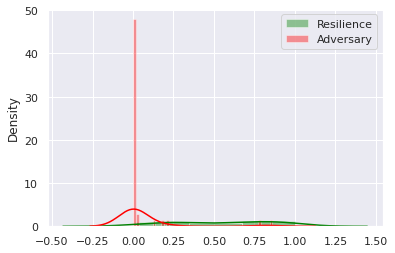

In [ ]:
estimator_category = "Faithfulness"
estimator_name = "Pixel-Flipping"
test = "Model Resilience Test"
intra_scores_res = np.array(list(benchmark[estimator_category][estimator_name]["intra_scores"][test].values())).flatten()
test = "Model Adversary Test"
intra_scores_adv = np.array(list(benchmark[estimator_category][estimator_name]["intra_scores"][test].values())).flatten()

sns.distplot(intra_scores_res, color="green", label="Resilience")
sns.distplot(intra_scores_adv, color="red", label="Adversary")
plt.legend();

### Get all scores over one specific XAI method.

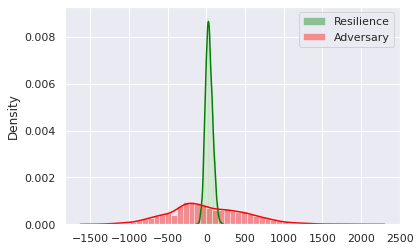

In [ ]:
iter = "1"
xai_method = "IntegratedGradients"
test = "Model Resilience Test"
eval_scores_perturbed_res = benchmark[estimator_category][estimator_name]["eval_scores_perturbed"][test][iter][xai_method]
test = "Model Adversary Test"
eval_scores_perturbed_adv = benchmark[estimator_category][estimator_name]["eval_scores_perturbed"][test][iter][xai_method]

sns.distplot(eval_scores_perturbed_res, color="green", label="Resilience")
sns.distplot(eval_scores_perturbed_adv, color="red", label="Adversary")
plt.legend();

### How does the score distribution change over different XAI methods?

In [ ]:
intra_scores

[[0.7926824644589086,
  0.24466799870445965,
  0.8660287796622268,
  0.6276106923688685,
  0.016661745769866947],
 [0.6655428307293754,
  0.34951232333494153,
  0.7517884445816739,
  0.014750140789962259,
  0.19725036442712607]]

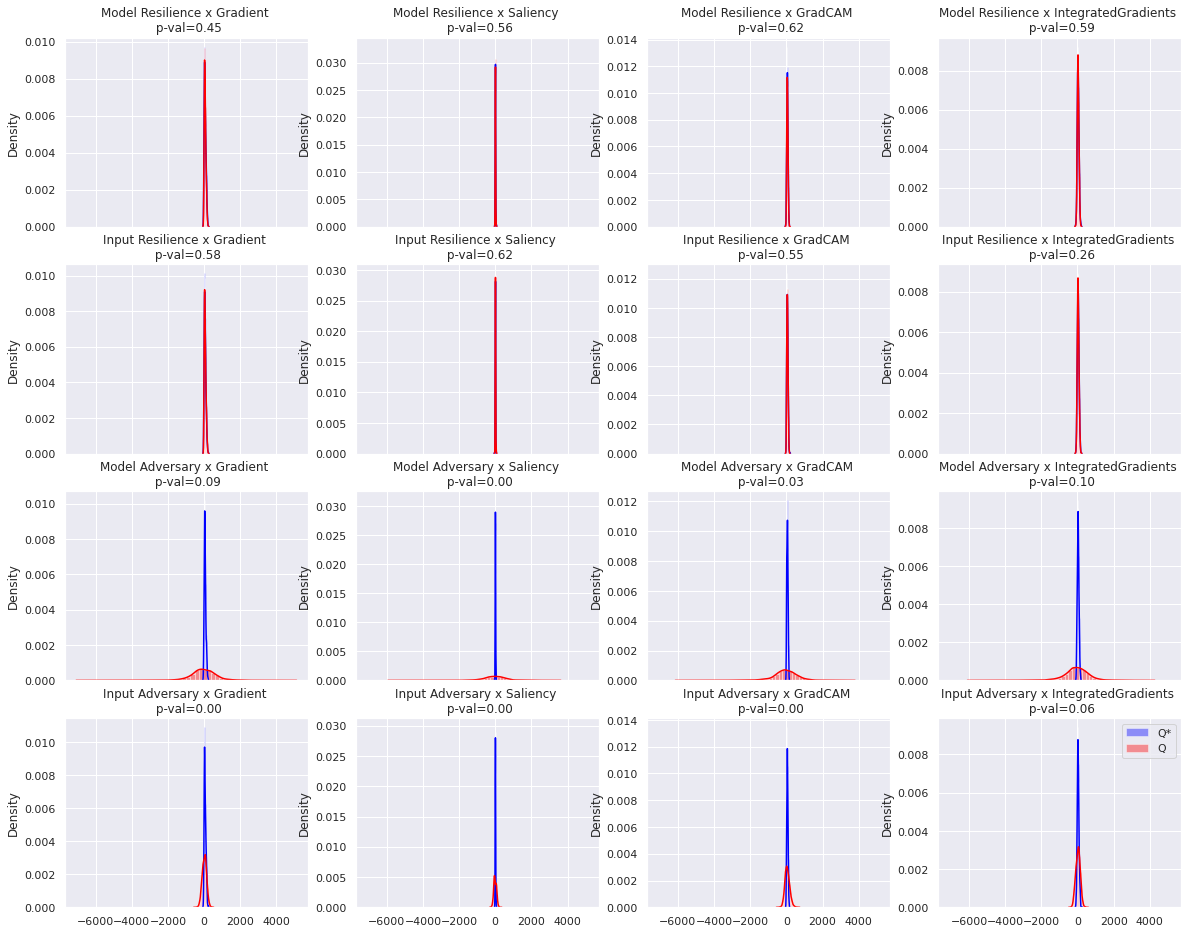

In [ ]:
test = "Model Adversary Test"

# Plot it!
fig, axs = plt.subplots(4, 4, sharex=True, figsize=(20, 16))
for ti, test in enumerate(analyser_suite):
    for xi, xai_method in enumerate(xai_methods):
        eval_scores = benchmark[estimator_category][estimator_name]["eval_scores"][test][xai_method]
        sns.distplot(eval_scores, color="blue", ax=axs[ti, xi], label="Q*")
        perturbed_scores=[]
        for iter in range(2):
            eval_scores_perturbed = benchmark[estimator_category][estimator_name]["eval_scores_perturbed"][test][str(iter)][xai_method]
            perturbed_scores.append(eval_scores_perturbed)
        sns.distplot(np.array(perturbed_scores).flatten(), color="red", ax=axs[ti, xi], label="Q")
        intra_scores = benchmark[estimator_category][estimator_name]["intra_scores"][test][xai_method]
        axs[ti, xi].set_title(f"{test.replace(' Test', '')} x {xai_method} \n p-val={np.mean(intra_scores):.2f}")
plt.legend()
plt.show()

## Redundant

In [ ]:
estimator_category = "Complexity"
estimator_name = "Sparseness" #
perturbation_type = "Model"

intra_scores_res = np.array(list(benchmark[estimator_category][estimator_name]["intra_scores"][f"{perturbation_type} Resilience Test"].values())).flatten()
intra_scores_adv = np.array(list(benchmark[estimator_category][estimator_name]["intra_scores"][f"{perturbation_type} Adversary Test"].values())).flatten()
inter_scores_res = np.array(benchmark[estimator_category][estimator_name]['inter_scores'][f"{perturbation_type} Resilience Test"])
inter_scores_adv = np.array(benchmark[estimator_category][estimator_name]['inter_scores'][f"{perturbation_type} Adversary Test"])

#sns.distplot(intra_scores_res, color="green", label="Resilience")
#sns.distplot(intra_scores_adv, color="red", label="Adversary")
#plt.show()

fig = plt.figure(figsize=(5, 5))
ax = plt.axes()
ax.set_facecolor("white")

print([intra_scores_res.mean(), inter_scores_res.mean(), intra_scores_adv.mean(), inter_scores_adv.mean()])
plt.fill([-1, -1, 1, -1], [-1, 1, -1, -1], color="black", alpha=0.25)
plt.fill([-1, -1, intra_scores_adv.mean(), inter_scores_adv.mean()], [-inter_scores_res.mean(), intra_scores_res.mean(), 0, -1], color="red", alpha=0.5)
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.axis('off');